# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from collections import Counter
import os
import joblib

# Collect and Load Dataset,  Data Cleaning & Preprocessing

In [4]:
movies = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/movies.csv")
ratings = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/ratings.csv")
tags = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/tags.csv")
genome_scores = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/genome-scores.csv")
genome_tags = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/genome-tags.csv")
links = pd.read_csv(r"Personalized_Recommendation_System_Project/ml-25m/links.csv")

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
### Check Missing Values
datasets = {
    "movies": movies,
    "ratings": ratings,
    "tags": tags,
    "genome_scores": genome_scores,
    "genome_tags": genome_tags,
    "links": links
}

for name, df in datasets.items():
    print(f"Missing values in {name}:")
    print(df.isnull().sum(), "\n")

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64 

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

Missing values in tags:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64 

Missing values in genome_scores:
movieId      0
tagId        0
relevance    0
dtype: int64 

Missing values in genome_tags:
tagId    0
tag      0
dtype: int64 

Missing values in links:
movieId      0
imdbId       0
tmdbId     107
dtype: int64 



In [8]:
###  Drop Rows with Missing Values
for name, df in datasets.items():
    datasets[name] = df.dropna()
    print(f"Cleaned {name} - shape: {datasets[name].shape}")

Cleaned movies - shape: (62423, 3)
Cleaned ratings - shape: (25000095, 4)
Cleaned tags - shape: (1093344, 4)
Cleaned genome_scores - shape: (15584448, 3)
Cleaned genome_tags - shape: (1128, 2)
Cleaned links - shape: (62316, 3)


In [10]:
### To save these cleaned datasets
# Define the folder to save the cleaned data
output_path = "Personalized_Recommendation_System_Project"
os.makedirs(output_path, exist_ok=True)

# Save each cleaned DataFrame to CSV
for name, df in datasets.items():
    file_path = os.path.join(output_path, f"{name}_cleaned.csv")
    df.to_csv(file_path, index=False)
    print(f"📌 Saved: {file_path}")

📌 Saved: Documents/Personalized_Recommendation_System_Project\movies_cleaned.csv
📌 Saved: Documents/Personalized_Recommendation_System_Project\ratings_cleaned.csv
📌 Saved: Documents/Personalized_Recommendation_System_Project\tags_cleaned.csv
📌 Saved: Documents/Personalized_Recommendation_System_Project\genome_scores_cleaned.csv
📌 Saved: Documents/Personalized_Recommendation_System_Project\genome_tags_cleaned.csv
📌 Saved: Documents/Personalized_Recommendation_System_Project\links_cleaned.csv


In [11]:
### Convert TimeStamps in Ratings and Tags
# Convert Ratings timestamp column safely
ratings_timestamp = pd.to_datetime(datasets['ratings']['timestamp'], unit='s')
datasets['ratings'] = datasets['ratings'].copy()
datasets['ratings']['timestamp'] = ratings_timestamp

# Convert Tags timestamp
tags_timestamp = pd.to_datetime(datasets['tags']['timestamp'], unit='s')
datasets['tags'] = datasets['tags'].copy()
datasets['tags']['timestamp'] = tags_timestamp

In [12]:
### Normalize Ratings (0–1 scale)
scaler = MinMaxScaler()
ratings['normalized_rating'] = scaler.fit_transform(ratings[['rating']])

# Preview
ratings[['userId', 'movieId', 'rating', 'normalized_rating']].head()

,userId,movieId,rating,normalized_rating
0,1,296,5.0,1.000000
1,1,306,3.5,0.666667
2,1,307,5.0,1.000000
3,1,665,5.0,1.000000
4,1,899,3.5,0.666667


In [13]:
datasets['ratings'].drop(columns=['normalized_rating'], inplace=True, errors='ignore')
print(datasets['ratings'].columns.tolist())

['userId', 'movieId', 'rating', 'timestamp']


In [14]:
### Merge Ratings with Movies for Analysis and Visualization
ratings_movies = pd.merge(ratings, movies, on="movieId")
ratings_movies.head()

,userId,movieId,rating,timestamp,normalized_rating,title,genres
0,1,296,5.0,1147880044,1.000000,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,0.666667,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,1.000000,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,1.000000,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,0.666667,Singin' in the Rain (1952),Comedy|Musical|Romance


In [15]:
# File path and save the cleaned DataFrame
output_path = "Personalized_Recommendation_System_Project"
os.makedirs(output_path, exist_ok=True)

csv_file_path = os.path.join(output_path, "cleaned_ratings_movies.csv")
ratings_movies.to_csv(csv_file_path, index=False)

In [16]:
# Saved and show first few rows
print(f"📌 Cleaned file saved to: {csv_file_path}")
print("\n💿 Sample of cleaned data:")
print(ratings_movies.head())

📌 Cleaned file saved to: Documents/Personalized_Recommendation_System_Project\cleaned_ratings_movies.csv

💿 Sample of cleaned data:
   userId  movieId  rating   timestamp  normalized_rating  \
0       1      296     5.0  1147880044           1.000000   
1       1      306     3.5  1147868817           0.666667   
2       1      307     5.0  1147868828           1.000000   
3       1      665     5.0  1147878820           1.000000   
4       1      899     3.5  1147868510           0.666667   

                                              title  \
0                               Pulp Fiction (1994)   
1  Three Colors: Red (Trois couleurs: Rouge) (1994)   
2  Three Colors: Blue (Trois couleurs: Bleu) (1993)   
3                                Underground (1995)   
4                        Singin' in the Rain (1952)   

                        genres  
0  Comedy|Crime|Drama|Thriller  
1                        Drama  
2                        Drama  
3             Comedy|Drama|War  
4    

In [17]:
# EDA – Explore User-Item Interactions
##  Number of Unique Users and Movies
print("📌 Dataset Overview:")
print(f"🙋‍♂️ Total unique users:  {ratings_movies['userId'].nunique()}")
print(f"📽️ Total unique movies: {ratings_movies['movieId'].nunique()}")
print(f"⭐ Average rating:       {round(ratings_movies['rating'].mean(), 2)}")
print(f"📮 Total ratings:        {ratings_movies.shape[0]}")

📌 Dataset Overview:
🙋‍♂️ Total unique users:  162541
📽️ Total unique movies: 59047
⭐ Average rating:       3.53
📮 Total ratings:        25000095


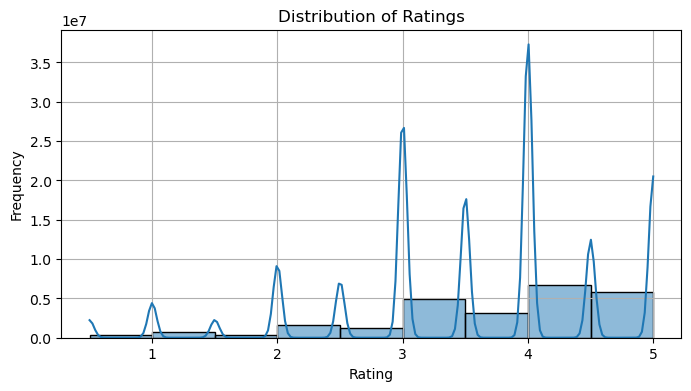

In [18]:
### EDA to Understand User_Item Interactions
#  1.  Distribution of Ratings
plt.figure(figsize=(8, 4))
sns.histplot(ratings_movies['rating'], bins=9, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

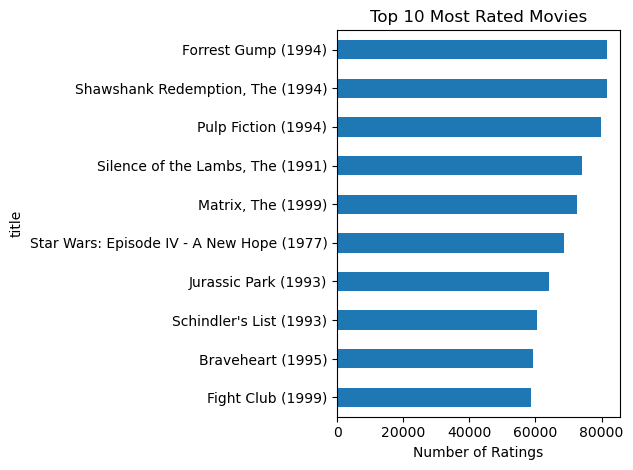

In [19]:
###  Most Rated Movies
top_movies = ratings_movies['title'].value_counts().head(10)
top_movies.plot(kind='barh', title='Top 10 Most Rated Movies')
plt.gca().invert_yaxis()
plt.xlabel("Number of Ratings")
plt.tight_layout()
plt.show()

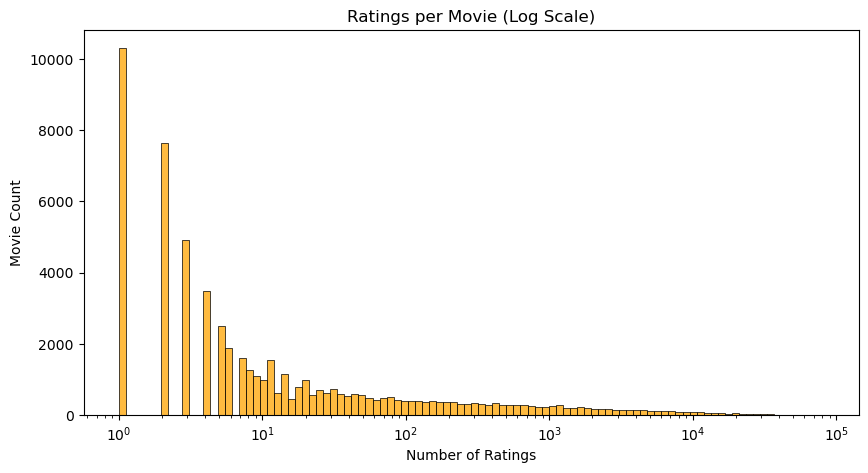

In [20]:
# 2.  Ratings per Movie
movie_rating_counts = ratings_movies.groupby('movieId')['rating'].count()

plt.figure(figsize=(10, 5))
sns.histplot(movie_rating_counts, bins=100, log_scale=True, color='orange')
plt.title('Ratings per Movie (Log Scale)')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Count')
plt.show()

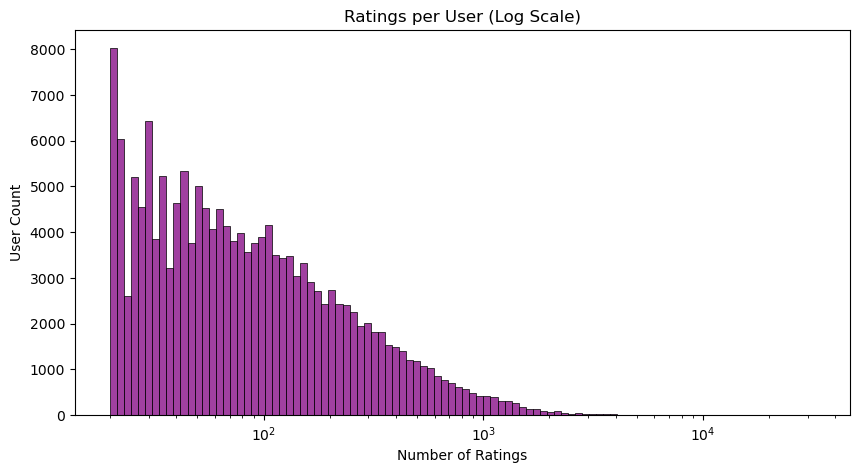

In [21]:
# 3.  Ratings per User
user_rating_counts = ratings_movies.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=100, log_scale=True, color='purple')
plt.title('Ratings per User (Log Scale)')
plt.xlabel('Number of Ratings')
plt.ylabel('User Count')
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_16924\332727002.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')


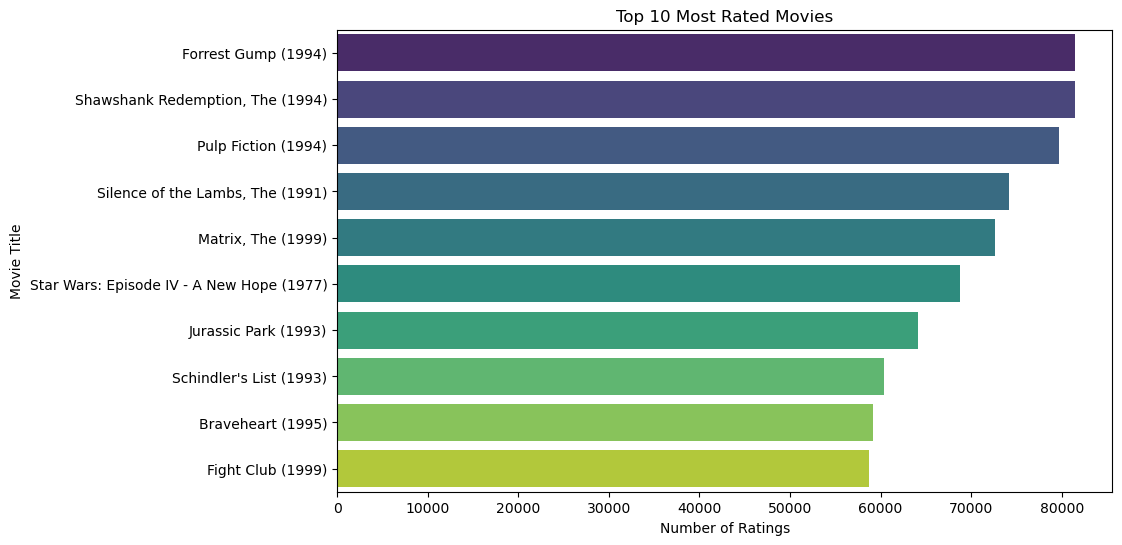

In [22]:
# 4.  Top 10 Most Rated Movies
top_movies = ratings_movies['title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_16924\2749248384.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated['average_rating'], y=top_rated.index, palette='coolwarm')


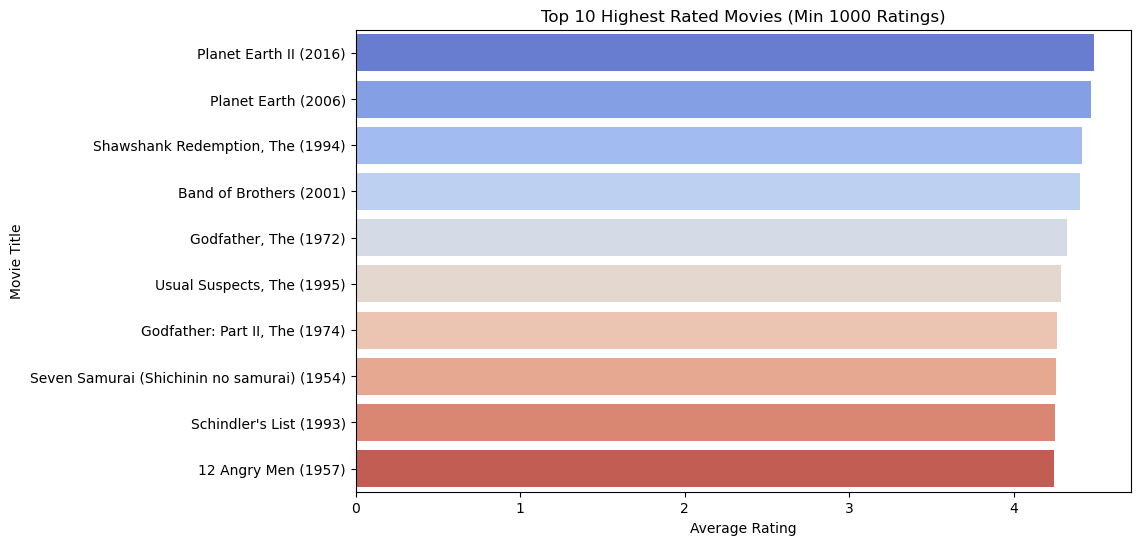

In [23]:
# 5.  Top 10 Highest Rated Popular Movies (1000+ Ratings)
movie_stats = ratings_movies.groupby('title').agg(
    average_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
)

popular = movie_stats[movie_stats['rating_count'] >= 1000]
top_rated = popular.sort_values('average_rating', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_rated['average_rating'], y=top_rated.index, palette='coolwarm')
plt.title('Top 10 Highest Rated Movies (Min 1000 Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_16924\1144260390.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')


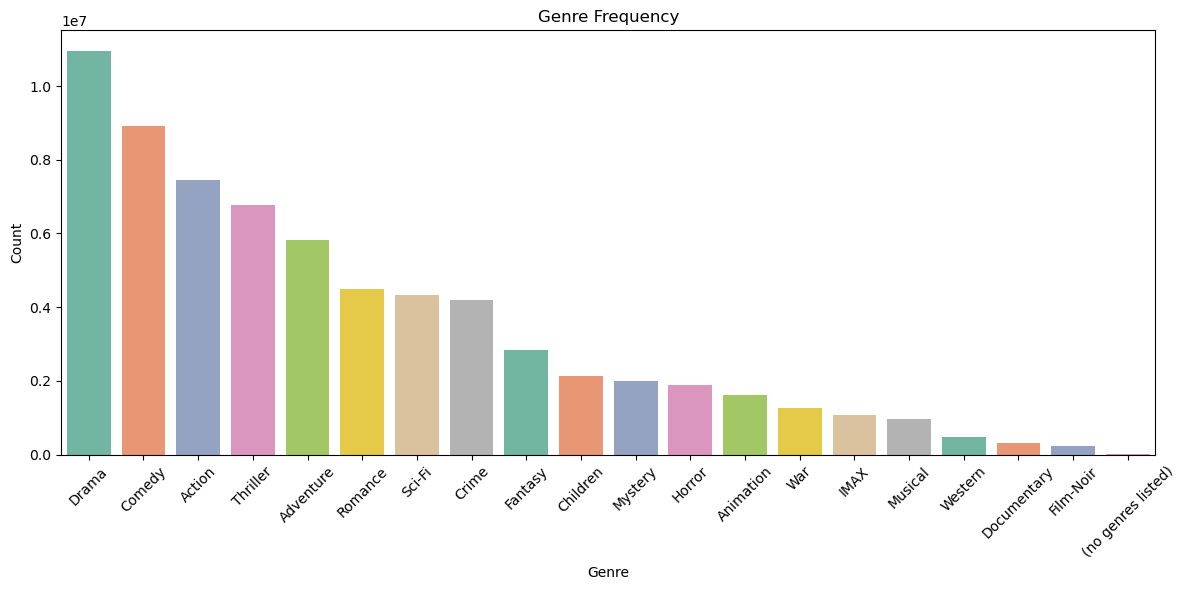

In [24]:
# 6.  Genre Distribution
# Break into Chunks
chunk_size = 1_000_000
genre_counter = Counter()

for i in range(0, len(ratings_movies), chunk_size):
    chunk = ratings_movies.iloc[i:i+chunk_size]
    genres_split = chunk['genres'].str.split('|')
    genres_flat = genres_split.explode()
    genre_counter.update(genres_flat.dropna())

# Convert to DataFrame
genre_counts = pd.Series(genre_counter).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')
plt.xticks(rotation=45)
plt.title('Genre Frequency')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#  Build collaborative filtering models - User-based & Item-based.

# 1. Load and Prepare Data for Collabrative Filtering Models

In [27]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic, SVD, NMF, accuracy
import warnings
warnings.filterwarnings("ignore")

# Fix: Specify the full path to the ratings.csv file
ratings = pd.read_csv("Personalized_Recommendation_System_Project/ml-25m/ratings.csv")

# Sample a manageable subset
ratings_sample = ratings.sample(n=100_000, random_state=42)
ratings_sample['userId'] = ratings_sample['userId'].astype('int32')
ratings_sample['movieId'] = ratings_sample['movieId'].astype('int32')
ratings_sample['rating'] = ratings_sample['rating'].astype('float32')

# Prepare Surprise Dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 2.  User-based Collaborative Filtering (k-NN with user similarity)

In [29]:
# User-based CF using cosine similarity
# User-based CF
from surprise import KNNBasic

# Use cosine similarity, user-based
sim_user = {'name': 'cosine', 'user_based': False}
model_user = KNNBasic(sim_options=sim_user)
model_user.fit(trainset)
pred_user = model_user.test(testset)

# Evaluation
print("📊 User-based CF RMSE:", accuracy.rmse(pred_user))
print("📊 User-based CF MAE:", accuracy.mae(pred_user))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0712
📊 User-based CF RMSE: 1.071231047789878
MAE:  0.8478
📊 User-based CF MAE: 0.84783022


# 3.  Item-based Collaborative Filtering

In [31]:
# Item-based CF using cosine similarity
sim_item = {'name': 'cosine', 'user_based': False}
model_item = KNNBasic(sim_options=sim_item)
model_item.fit(trainset)
pred_item = model_item.test(testset)

# Evaluation
print("📊 Item-based CF RMSE:", accuracy.rmse(pred_item))
print("📊 Item-based CF MAE:", accuracy.mae(pred_item))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0712
📊 Item-based CF RMSE: 1.071231047789878
MAE:  0.8478
📊 Item-based CF MAE: 0.84783022


#  4.Matrix Factorization (SVD)

In [33]:
from surprise import SVD

model_svd = SVD()
model_svd.fit(trainset)
pred_svd = model_svd.test(testset)

print("🎯 SVD RMSE:", accuracy.rmse(pred_svd))
print("🎯 SVD MAE:", accuracy.mae(pred_svd))

RMSE: 0.9766
🎯 SVD RMSE: 0.9765783597926571
MAE:  0.7560
🎯 SVD MAE: 0.7560386287586415


#  5.Matrix Factorization (NMF)

In [35]:
from surprise import NMF

model_nmf = NMF()
model_nmf.fit(trainset)
pred_nmf = model_nmf.test(testset)

print("🎯 NMF RMSE:", accuracy.rmse(pred_nmf))
print("🎯 NMF MAE:", accuracy.mae(pred_nmf))

RMSE: 1.1524
🎯 NMF RMSE: 1.1523632365397503
MAE:  0.9115
🎯 NMF MAE: 0.9114699795999402


##  6.Precision@K

In [41]:
from collections import defaultdict

def precision_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        n_rel = sum((true_r >= threshold) for (_, true_r) in top_k)
        precisions.append(n_rel / k)

    return sum(precisions) / len(precisions)

print("📌 Precision@5 (User CF):", precision_at_k(pred_user))
print("📌 Precision@5 (SVD):", precision_at_k(pred_svd))

📌 Precision@5 (User CF): 0.1491966426858513
📌 Precision@5 (SVD): 0.1492326139088729


In [43]:
# To Save the Models using Joblib
output_dir = "Personalized_Recommendation_System_Project"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(model_user, os.path.join(output_dir, "user_cf_model.joblib"))
joblib.dump(model_item, os.path.join(output_dir, "item_cf_model.joblib"))
joblib.dump(model_svd, os.path.join(output_dir, "svd_model.joblib"))
joblib.dump(model_nmf, os.path.join(output_dir, "nmf_model.joblib"))

print("📌 All models saved successfully using joblib.")

📌 All models saved successfully using joblib.


# Build a Content-based Recommendation system using TF-IDF on Metadata

# 1. Load & Preprocess Metadata

In [46]:
# Load your cleaned dataset
file_path = "cleaned path"
chunk_iter = pd.read_csv(file_path, chunksize=100000)

# Combine First Few Rows
df = pd.concat([chunk for _, chunk in zip(range(2), chunk_iter)], ignore_index=True)

# Create metadata by combining title and genres
df['metadata'] = df['title'] + ' ' + df['genres'].fillna('')
print(df[['title', 'genres', 'metadata']].head(10))

                                              title  \
0                               Pulp Fiction (1994)   
1  Three Colors: Red (Trois couleurs: Rouge) (1994)   
2  Three Colors: Blue (Trois couleurs: Bleu) (1993)   
3                                Underground (1995)   
4                        Singin' in the Rain (1952)   
5                              Dirty Dancing (1987)   
6                               Delicatessen (1991)   
7                                        Ran (1985)   
8   Seventh Seal, The (Sjunde inseglet, Det) (1957)   
9              Bridge on the River Kwai, The (1957)   

                        genres  \
0  Comedy|Crime|Drama|Thriller   
1                        Drama   
2                        Drama   
3             Comedy|Drama|War   
4       Comedy|Musical|Romance   
5        Drama|Musical|Romance   
6         Comedy|Drama|Romance   
7                    Drama|War   
8                        Drama   
9          Adventure|Drama|War   

                   

In [52]:
###  Remove Duplicates
df_unique = df.drop_duplicates(subset='movieId')

In [53]:
### Top 500 Popular Movies to select
top_500_ids = df['movieId'].value_counts().head(500).index
df_subset = df[df['movieId'].isin(top_500_ids)].drop_duplicates('movieId').reset_index(drop=True)

In [74]:
# Rebuild metadata from df_subset
df_subset['metadata'] = df_subset['title'].fillna('') + ' ' + df_subset['genres'].fillna('')

In [76]:
### 2. Apply TF-IDF Vectorization
# Initialized the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['metadata'])

In [80]:
### 3. Cosine Simillarity --- Compute Top-N Similar Movies for Each Movie
# Compute cosine similarity matrix in bulk
from tqdm import tqdm

def compute_top_n_similarities(matrix, top_n=10):
    top_sim = {}
    for i in tqdm(range(matrix.shape[0]), desc="** Computing Similarities"):
        sim_row = cosine_similarity(matrix[i], matrix).flatten()
        top_indices = np.argpartition(-sim_row, top_n + 1)[:top_n + 1]
        top_indices = top_indices[top_indices != i]  # exclude self
        sorted_top = top_indices[np.argsort(-sim_row[top_indices])]
        top_sim[i] = list(zip(sorted_top, sim_row[sorted_top]))
    return top_sim

top_similarities = compute_top_n_similarities(tfidf_matrix)

** Computing Similarities: 100%|██████████| 200000/200000 [1:47:38<00:00, 30.96it/s]  


In [84]:
#### Save Top - Similarities
save_path = os.path.expanduser("Personalized_Recommendation_System_Project/top_similarities.joblib")
joblib.dump(top_similarities, save_path)
print(f"✅ Top similarities saved to: {save_path}")

✅ Top similarities saved to: Documents/Personalized_Recommendation_System_Project/top_similarities.joblib


In [86]:
### 4. Define Recommendation Function
#### Mapping Movie Index to Title 
title_mapping = df_subset['title'].reset_index(drop=True)

def get_top_recommendations(movie_title, top_similarities=top_similarities, title_mapping=title_mapping):
    try:
        idx = df_subset[df_subset['title'].str.lower() == movie_title.lower()].index[0]
        similar_movies = top_similarities.get(idx)

        if not similar_movies:
            return ["🤖 No similar movies found."]

        recommended_titles = [
            title_mapping[i] for i, _ in similar_movies if i < len(title_mapping)
        ]
        return recommended_titles

    except IndexError:
        return ["⚠️ Movie title not found in the top-500 subset."]
    except Exception as e:
        return [f"⚙️ Error: {str(e)}"]

In [90]:
# Display all movie titles in the top-500 subset
print("🎞️ Available titles in the top-500 subset:")
for title in df_subset['title']:
    print("   •", title)

🎞️ Available titles in the top-500 subset:
   • Pulp Fiction (1994)
   • Singin' in the Rain (1952)
   • Dirty Dancing (1987)
   • Bridge on the River Kwai, The (1957)
   • Gattaca (1997)
   • Back to the Future Part II (1989)
   • Back to the Future Part III (1990)
   • Run Lola Run (Lola rennt) (1998)
   • Requiem for a Dream (2000)
   • Moulin Rouge (2001)
   • Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
   • Lord of the Rings: The Two Towers, The (2002)
   • City of God (Cidade de Deus) (2002)
   • Finding Nemo (2003)
   • Pirates of the Caribbean: The Curse of the Black Pearl (2003)
   • Lost in Translation (2003)
   • Eternal Sunshine of the Spotless Mind (2004)
   • Shrek 2 (2004)
   • Toy Story (1995)
   • Mr. Holland's Opus (1995)
   • Braveheart (1995)
   • Apollo 13 (1995)
   • Rob Roy (1995)
   • French Kiss (1995)
   • Star Wars: Episode IV - A New Hope (1977)
   • Legends of the Fall (1994)
   • Shawshank Redemption, The (1994)
   • Clear and Present Danger (1994

In [92]:
### Preview
movie_title = "Gravity (2013)"
recommendations = get_top_recommendations(movie_title)
print(f"\n🎬 Recommendations for '{movie_title}':")
for title in recommendations:
    print("   •", title)


🎬 Recommendations for 'Gravity (2013)':


# 1. Hybrid Recommendation System (Content-Based + Collaborative)

In [95]:
#### content_scores and collaborative_scores are both dicts of movieId 

def hybrid_score(content_scores, collaborative_scores, alpha=0.5):
    # Combine weighted scores from both models
    combined = {}
    all_movie_ids = set(content_scores) | set(collaborative_scores)

    for movie_id in all_movie_ids:
        cbf = content_scores.get(movie_id, 0)
        cf = collaborative_scores.get(movie_id, 0)
        combined[movie_id] = alpha * cbf + (1 - alpha) * cf

    return sorted(combined.items(), key=lambda x: -x[1])

# 2. Fine-Tuning Recommendations with User Feedback Loops

In [100]:
### 2. User Feedback Profile
user_profile = {"liked": set(), "disliked": set()}

def update_profile(movie_id, feedback):
    if feedback == "like":
        user_profile["liked"].add(movie_id)
        user_profile["disliked"].discard(movie_id)
    elif feedback == "dislike":
        user_profile["disliked"].add(movie_id)
        user_profile["liked"].discard(movie_id)

def adjust_scores(base_scores):
    for movie_id in base_scores:
        if movie_id in user_profile["liked"]:
            base_scores[movie_id] *= 1.2  # boost
        elif movie_id in user_profile["disliked"]:
            base_scores[movie_id] *= 0.5  # dampen
    return base_scores

In [102]:
### Save the Models with joblib
# Define save path
save_dir = "save path"
os.makedirs(save_dir, exist_ok=True)

# Save all model components
joblib.dump(hybrid_score, os.path.join(save_dir, "hybrid_score_function.pkl"))
joblib.dump(update_profile, os.path.join(save_dir, "update_profile_function.pkl"))
joblib.dump(adjust_scores, os.path.join(save_dir, "adjust_scores_function.pkl"))
joblib.dump(user_profile, os.path.join(save_dir, "user_profile.pkl"))

print("✅ Hybrid model and feedback components saved successfully.")

✅ Hybrid model and feedback components saved successfully.


# Compare and document results from all models.

In [107]:
###  Evaluate Models ---- Evaluate and Compare All Models Using Precision@K
### 1. Define precision_at_k() Function
def precision_at_k(recommended_ids, relevant_ids, k=10):
    recommended_k = recommended_ids[:k]
    relevant_set = set(relevant_ids)
    hits = sum([1 for movie_id in recommended_k if movie_id in relevant_set])
    return hits / k

In [109]:
### 2.Simulated Scores for Evaluation
# Simulated model scores -- movieId: score
content_scores = {1: 0.9, 2: 0.7, 3: 0.3, 4: 0.1}
collaborative_scores = {1: 0.5, 2: 0.8, 5: 0.6}

# Simulated user feedback 
user_profile = {"liked": {1, 2}, "disliked": {4}}

# Relevant ground truth movies
relevant_movies = [1, 2]

In [111]:
### 3. Adjust Scores Using Feedback
def adjust_scores(base_scores):
    adjusted = base_scores.copy()
    for movie_id in adjusted:
        if movie_id in user_profile["liked"]:
            adjusted[movie_id] *= 1.2
        elif movie_id in user_profile["disliked"]:
            adjusted[movie_id] *= 0.5
    return adjusted

adjusted_cb = adjust_scores(content_scores)
adjusted_cf = adjust_scores(collaborative_scores)

In [113]:
adjusted_cb
adjusted_cf

{1: 0.6, 2: 0.96, 5: 0.6}

In [117]:
### 4. Hybrid Score Function
def hybrid_score(content_scores, collaborative_scores, alpha=0.5):
    combined = {}
    all_movie_ids = set(content_scores) | set(collaborative_scores)
    for movie_id in all_movie_ids:
        cbf = content_scores.get(movie_id, 0)
        cf = collaborative_scores.get(movie_id, 0)
        combined[movie_id] = alpha * cbf + (1 - alpha) * cf
    return sorted(combined.items(), key=lambda x: -x[1])

In [119]:
### 5. Generate Top-K Recommendations for Each Model
# Get top-K movie IDs for each model
top_k = 5

# Content-Based Filtering (CBF)
cbf_recs = sorted(adjusted_cb.items(), key=lambda x: -x[1])
cbf_top_ids = [movie_id for movie_id, _ in cbf_recs]

# Collaborative Filtering (CF)
cf_recs = sorted(adjusted_cf.items(), key=lambda x: -x[1])
cf_top_ids = [movie_id for movie_id, _ in cf_recs]

# Hybrid Model
hybrid_recs = hybrid_score(adjusted_cb, adjusted_cf, alpha=0.5)
hybrid_top_ids = [movie_id for movie_id, _ in hybrid_recs]

In [121]:
### 6. Evaluate and Compare Using Precision@K
# Evaluate
p_cbf = precision_at_k(cbf_top_ids, relevant_movies, k=top_k)
p_cf = precision_at_k(cf_top_ids, relevant_movies, k=top_k)
p_hybrid = precision_at_k(hybrid_top_ids, relevant_movies, k=top_k)

# Print Results
print("\n📊 Model Evaluation (Precision@5):")
print(f"🧠 Content-Based Filtering:     {p_cbf:.2f}")
print(f"👥 Collaborative Filtering:     {p_cf:.2f}")
print(f"🔀 Hybrid Recommendation:       {p_hybrid:.2f}")


📊 Model Evaluation (Precision@5):
🧠 Content-Based Filtering:     0.40
👥 Collaborative Filtering:     0.40
🔀 Hybrid Recommendation:       0.40
